# Analyze the results given by NAS

## Build the network given by NAS 

In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')


import iterative_naive_nas

from sklearn.model_selection import train_test_split

#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import numpy as np

import custom_training

import utils.losses_utils as losses

import utils.data_utils as data_utils

import utils.viz_utils as viz

import matplotlib.pyplot as plt

import matplotlib.animation as animation


#50_partitions
#optimized_parameters = [8.50071696e-04, 3.55273289e-01, 3.86577994e-01, 9.51559796e-01,
# 1.00000000e+00, 1.60000000e+01, 1.57000000e+03]
#30_paritions
#optimized_parameters = [3.46661820e-04, 4.01120020e-01, 9.09580986e-01, 4.13090818e-01,
# 3.93104672e-01, 8.00000000e+00, 8.20000000e+02]
#25_partitions
#optimized_parameters = [6.80863834e-04, 4.68269339e-01, 4.51964628e-01, 1.80029101e-01,
# 3.94141219e-01, 2.00000000e+00, 7.20000000e+02]
#25_partitions_downsampled_3_absolute_zfmri
optimized_parameters = [2.70884979e-04, 5.85912076e-01, 7.90651030e-01, 6.76594653e-01, 2.93054361e-01, 6.40000000e+01, 4.95000000e+03]
#25_partitions_downsampled_4_absolute_zfmri
#optimized_parameters = [5.38778274e-04, 1.00000000e+00, 1.00000000e-04, 1.00000000e-04, 0.00000000e+00, 2.00000000e+00, 2.20000000e+03]
#21_partitions
#optimized_parameters = [1.0e-14, 1.0e-04, 1.0e+00, 1.0e-04, 0.0e+00, 1.6e+01, 8.2e+02]
#21_partitions_tanh
#optimized_parameters = [6.70771985e-04, 3.71587509e-01, 6.03183109e-01, 8.71381868e-01,
#                        3.22005780e-01, 2.00000000e+00, 1.82000000e+03]

learning_rate = float(optimized_parameters[0])
l1_penalization_eeg = float(optimized_parameters[1])
l1_penalization_bold = float(optimized_parameters[2])
l1_penalization_decoder = float(optimized_parameters[3])
loss_coefficient = float(optimized_parameters[4])
batch_size = int(optimized_parameters[5])
current_shape = int(optimized_parameters[6])
#eeg_hidden_shape = int(optimized_parameters[6])
#bold_hidden_shape = int(optimized_parameters[7])
#decoder_hidden_shape = int(optimized_parameters[8])

bold_shift=3
f_resample=1.8
n_partitions=25
by_partitions=False
partition_length=14
fmri_resolution_factor=3
mutate_bands=False
activation=''
dataset="01"

if(activation):
    eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    
else:
    eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions_downsampled_' + str(fmri_resolution_factor) + '_absolute_zfmri.json'
    bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions_downsampled_' + str(fmri_resolution_factor) + '_absolute_zfmri.json'
    decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions_downsampled_' + str(fmri_resolution_factor) + '_absolute_zfmri.json'

gpus=tf.config.list_physical_devices('GPU')
if(len(gpus)):
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

Starting to Load Data
(300, 882)
(300, 882)
(300, 882)
(300, 882)
(300, 882)
(300, 882)
(300, 882)
(300, 882)
(300, 882)
(300, 882)
(250, 64, 111, 14)
(250, 882, 14)
Finished Loading Data
Pairs Created


In [2]:
eeg_train, bold_train, mask, scalers = data_utils.load_data(list(range(10)),#n_voxels=n_voxels, 
                                                            bold_shift=bold_shift, 
                                                            n_partitions=n_partitions, 
                                                            by_partitions=by_partitions, 
                                                            partition_length=partition_length, 
                                                            f_resample=f_resample, 
                                                            mutate_bands=False,
                                                            fmri_resolution_factor=fmri_resolution_factor,
                                                            standardize_eeg=True, 
                                                            standardize_fmri=True,
                                                            dataset=dataset)

n_partitions=bold_train.shape[0]//bold_train.shape[2]
n_voxels = bold_train.shape[1]
interval_length = bold_train.shape[2]

eeg_train = eeg_train.reshape(eeg_train.shape+(1,))
bold_train = bold_train.reshape(bold_train.shape+(1,))

print("Finished Loading Data")

(300, 882)
(300, 882)
(300, 882)
(300, 882)
(300, 882)
(300, 882)
(300, 882)
(300, 882)
(300, 882)
(300, 882)
(250, 64, 111, 14)
(250, 882, 14)
Finished Loading Data


In [3]:
n_individuals_train=8
n_individuals_test=2

eeg_val = eeg_train[n_individuals_train*n_partitions:n_individuals_train*n_partitions+n_individuals_test*n_partitions]
eeg_train = eeg_train[:n_individuals_train*n_partitions]
bold_val = bold_train[n_individuals_train*n_partitions:n_individuals_train*n_partitions+n_individuals_test*n_partitions]
bold_train = bold_train[:n_individuals_train*n_partitions]

In [4]:
min_train = np.amin(bold_train)
min_val = np.amin(bold_val)

print(min_train, min_val)

max_value = np.amin([min_train, min_val])

print(max_value)

#bold_train = bold_train - max_value+0.001
#bold_test = bold_test - max_value+0.001

#bold_train = np.log(bold_train)
#bold_test = np.log(bold_test)

-6.0257654 -6.156808
-6.156808


In [5]:
eeg_train = eeg_train.astype('float32')
bold_train = bold_train.astype('float32')

eeg_val = eeg_val.astype('float32')
bold_val = bold_val.astype('float32')

eeg_test = None
bold_test = None

In [6]:
X_train_eeg, X_train_bold, tr_y, X_bold_train_target = data_utils.create_eeg_bold_pairs(eeg_train, bold_train, instances_per_individual=n_partitions)
X_val_eeg, X_val_bold, tv_y, X_bold_val_target = data_utils.create_eeg_bold_pairs(eeg_val, bold_val, instances_per_individual=n_partitions)

tr_y = np.array(tr_y, dtype='float32')
tv_y = np.array(tv_y, dtype='float32')

<IPython.core.display.Javascript object>


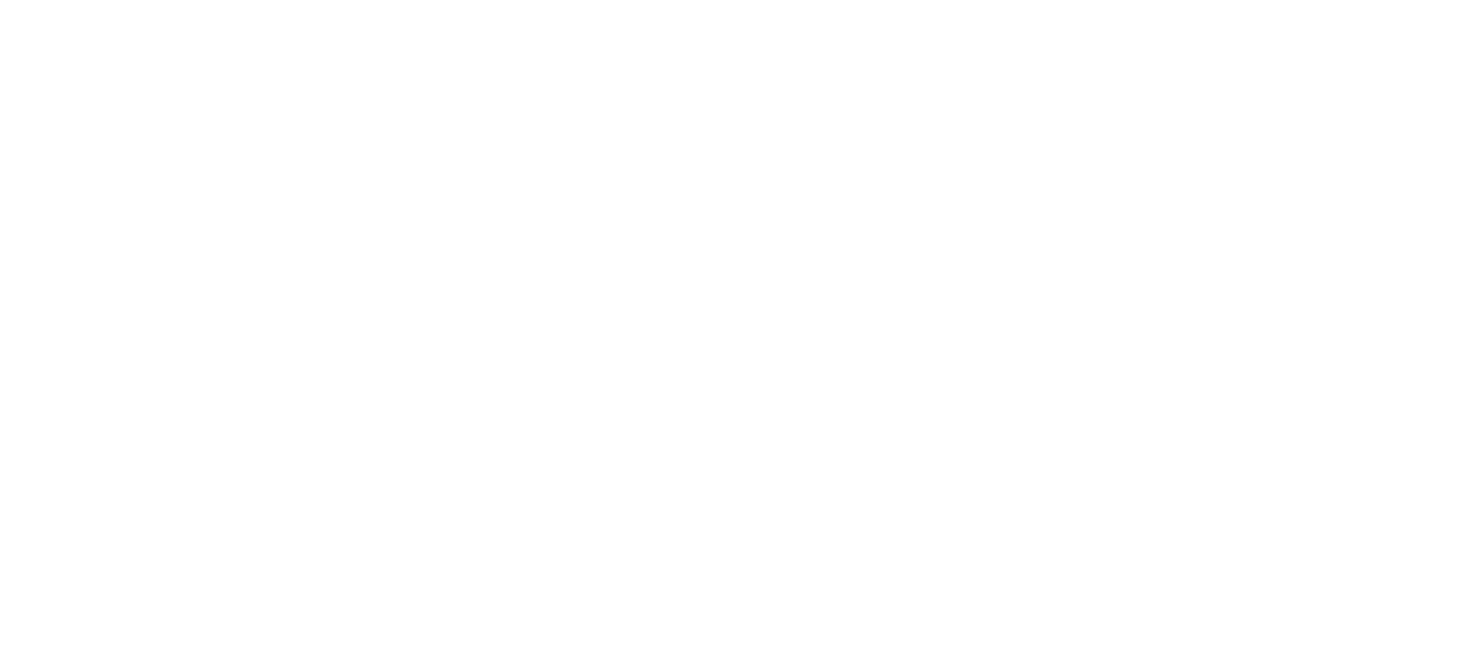

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [60]:
from numpy.linalg import norm

%matplotlib notebook

individual=0
normalize=False

real_mapping = np.copy(bold_train[individual,:, :, 0])
synth_mapping = np.copy(decoder_network(eeg_network(eeg_train)).numpy()[individual,:, :, 0])

if(normalize):
    for voxel in range(len(real_mapping[individual])):
        real_mapping[individual][voxel] = real_mapping[individual][voxel]/norm(real_mapping[individual][voxel])            
        synth_mapping[individual][voxel] = synth_mapping[individual][voxel]/norm(synth_mapping[individual][voxel])

n_frames = real_mapping.shape[1]

fig, axes = plt.subplots(1,2, figsize=(9,4))
ax1, ax2 = axes

ims1 = []
ims2 = []

for frame in range(n_frames):
    im1 = ax1.imshow(np.resize(real_mapping[:,frame], (50, 52)), 
                     cmap='gnuplot2', interpolation='nearest', animated=True)
    im2 = ax2.imshow(np.resize(synth_mapping[:,frame], (50, 52)), 
                     cmap='gnuplot2', interpolation='nearest', animated=True)
    ims1.append([im1])
    ims2.append([im2])

ani1 = animation.ArtistAnimation(fig, ims1, interval=500, blit=True, repeat_delay=1000)
ani2 = animation.ArtistAnimation(fig, ims2, interval=500, blit=True, repeat_delay=1000)

ani1_html= open("ani1.html","w")
ani1_html.write(ani1.to_html5_video())
ani1_html.close()

In [35]:
from utils import fmri_utils, viz_utils

import importlib
importlib.reload(viz_utils)

individual=1
timestep=13

synthesized = decoder_network(eeg_network(eeg_val)).numpy()[individual*n_partitions+timestep]
synthesized = synthesized.reshape((1,)+synthesized.shape[:-1])
bold_instance=bold_val[individual*n_partitions+timestep]
bold_instance=bold_instance.reshape((1,)+bold_instance.shape[:-1])

synth_vmin=np.amin(synthesized+np.abs(np.amin(synthesized))+0.1)
synth_vmax=np.amax(synthesized+np.abs(np.amin(synthesized))+0.1)
print(synth_vmin, synth_vmax)
real_vmin=np.amin(bold_instance+np.abs(np.amin(bold_instance))+0.1)
real_vmax=np.amax(bold_instance+np.abs(np.amin(bold_instance))+0.1)

synthesized_nifti_images = fmri_utils.get_nifti_from_set(synthesized+np.abs(np.amin(synthesized))+0.1, 
                                                      mask.mask_img_)
real_nifti_images = fmri_utils.get_nifti_from_set(bold_instance+np.abs(np.amin(bold_instance))+0.1, 
                                                                         mask.mask_img_)

viz_utils.plot_view_mask(synthesized_nifti_images[0], 
                        timestep=timestep, 
                        vmin=synth_vmin,
                        vmax=synth_vmax,
                        symmetric_cmap=False,
                        resampling_factor=fmri_resolution_factor,
                        save_file="../../results/tmp/plot_synthesized_test_"+str(individual)+"_"+str(timestep)+"_"+mode+".html")
viz_utils.plot_view_mask(real_nifti_images[0], 
                        timestep=timestep, 
                        vmin=real_vmin,
                        vmax=real_vmax,
                        symmetric_cmap=False,
                        resampling_factor=fmri_resolution_factor,
                        save_file="../../results/tmp/plot_real_"+str(individual)+"_"+str(timestep)+".html")

1.0456944 1.4411567


### Train the network

In [7]:
import importlib
importlib.reload(custom_training)
importlib.reload(losses)

eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

mode="lstm_zeeg_zfmri"
multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, 
                                                        corr_distance=True,
                                                        dist_function=losses.mean_volume_abs,#mean_volume_abs/euclidean /kl_loss
                                                        lstm=True,
                                                        gan=False,
                                                        gan_activation="softmax",
                                                        gan_output_dimension=1)

validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network,
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=5, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=batch_size, 
                                                            loss_function=losses.get_reconstruction_euclidean_volume_loss,
                                                            #linear_combination=loss_coefficient,
                                                            linear_combination=1.0,
                                                            clip_value_gradient=25.0, 
                                                            clip_value_loss=np.inf, 
                                                            margin_constrastive=1.0,#for lstm better 0.8
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y,
                                                            eeg_train=eeg_train, 
                                                            bold_train=bold_train, 
                                                            eeg_val=eeg_val, 
                                                            bold_val=bold_val,
                                                            X_bold_train_target=X_bold_train_target,
                                                            X_bold_val_target=X_bold_val_target,
                                                            verbose=False)

model_name = "LComb"

Encoder Loss:  1.8817949  || Decoder Loss:  14.74598 Validation Decoder Loss:  25.865757
Encoder Loss:  0.13294508  || Decoder Loss:  11.920447 Validation Decoder Loss:  25.46032
Encoder Loss:  0.09833735  || Decoder Loss:  10.238719 Validation Decoder Loss:  26.978903
Encoder Loss:  0.09859472  || Decoder Loss:  10.058322 Validation Decoder Loss:  26.976143
Encoder Loss:  0.13314576  || Decoder Loss:  10.227058 Validation Decoder Loss:  26.746914


train set mean:  -0.11019687898720697
train set std:  0.1300829406325605
test set mean:  -0.07054348222856574
test set std:  0.05093293356391636


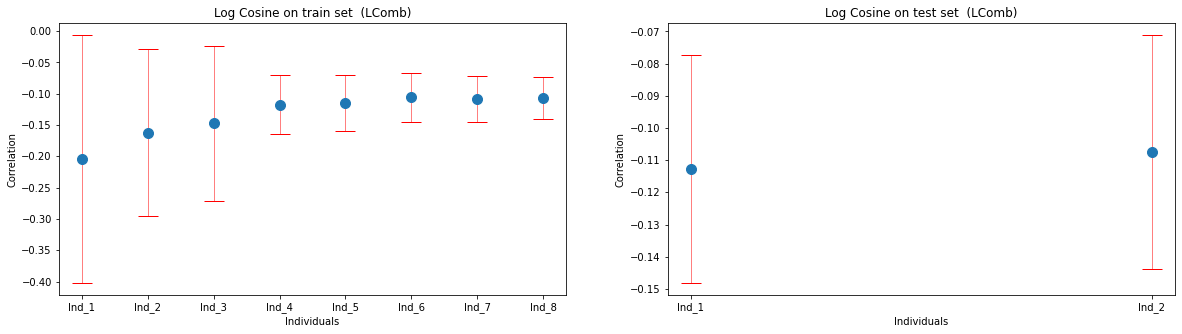

train set mean:  nan
train set std:  nan
test set mean:  nan
test set std:  nan


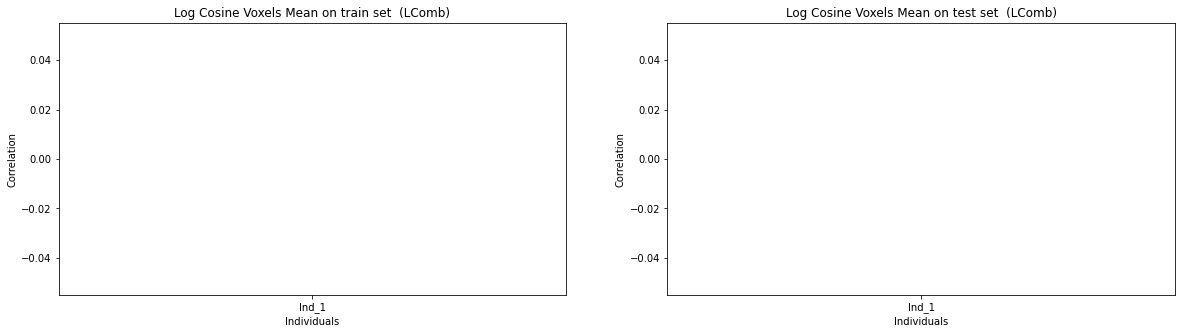

train set mean:  -0.09767537422372055
train set std:  0.0973099527967864
test set mean:  -0.06691191842615166
test set std:  0.047022094936527016


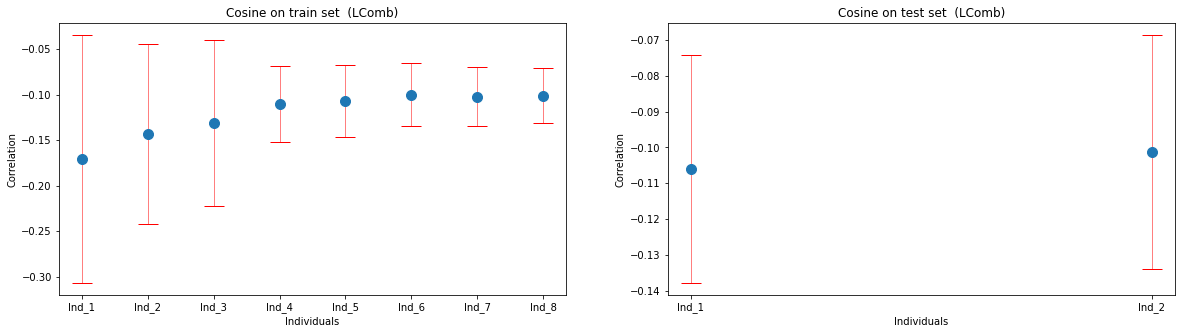

train set mean:  -inf
train set std:  nan
test set mean:  -inf
test set std:  nan


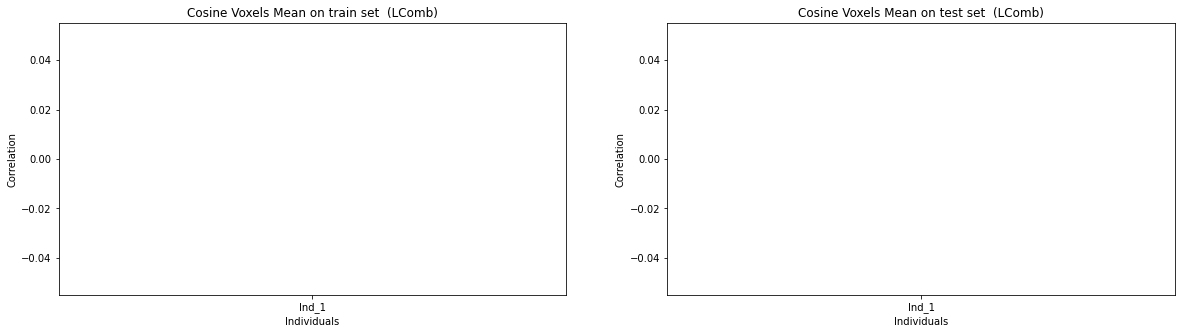

train set mean:  88.85343203825109
train set std:  40.293693761070614
test set mean:  87.65929794311523
test set std:  32.76954783411294


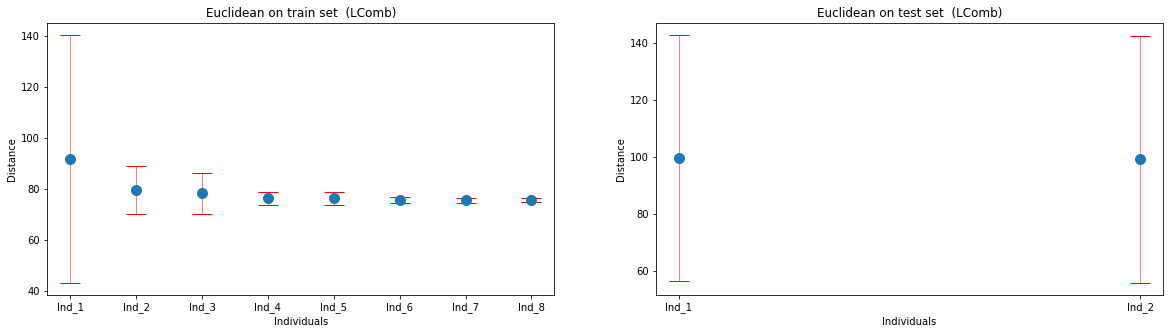

train set mean:  23.38836584371679
train set std:  9.391940048686934
test set mean:  23.16939090279972
test set std:  7.573745089936473


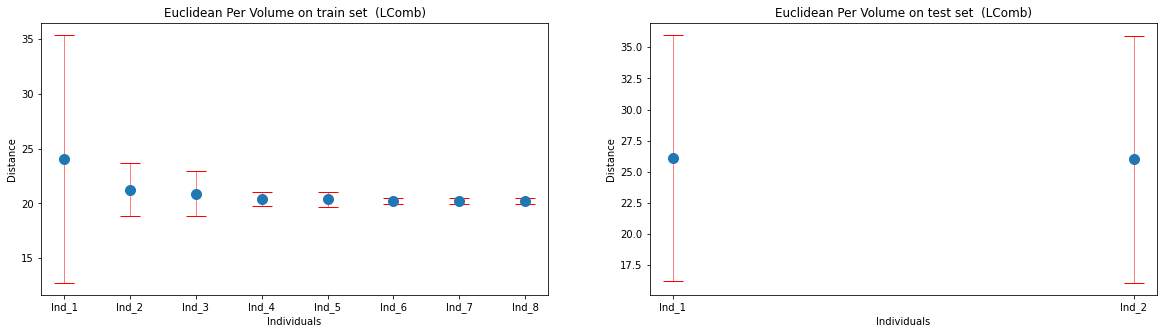

train set mean:  548.3341719683478
train set std:  278.6301217436426
test set mean:  538.6282878202551
test set std:  225.227841499804


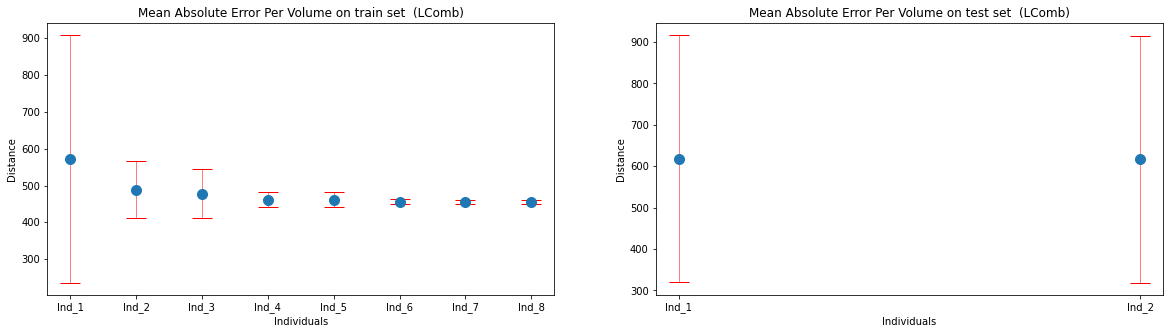

train set mean:  1.5923355406369357
train set std:  0.9601049907270082
test set mean:  1.6107298232176726
test set std:  1.3127181413657247


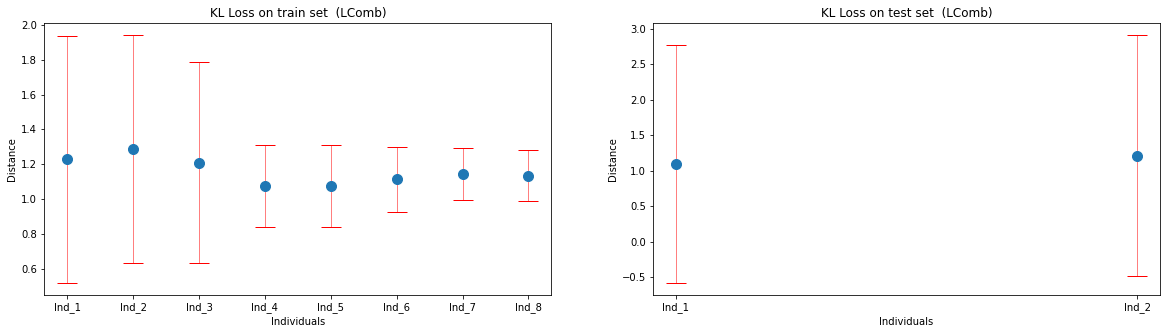

In [9]:
viz.plot_loss_results(eeg_train, bold_train, None, None, eeg_val, bold_val, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Try the same hyperparameters, but in an autoencoder training process without the bold branch

In [14]:
importlib.reload(losses)
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])


auto_encoder_model = custom_training.auto_encoder_network(eeg_input_shape, eeg_network, decoder_network)
mode="ae_zeeg_zfmri"
validation_loss = custom_training.autoencoder_training(X_train_eeg, 
                                                    X_train_bold, 
                                                    auto_encoder_model, 
                                                    epochs=5, 
                                                    auto_encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                    loss_function=losses.get_reconstruction_euclidean_volume_loss,
                                                    batch_size=batch_size, 
                                                    X_val_eeg=eeg_val, 
                                                    X_val_bold=bold_val,
                                                    eeg_train=eeg_train, 
                                                    bold_train=bold_train, 
                                                    eeg_val=eeg_val, 
                                                    bold_val=bold_val,
                                                    X_bold_train_target=X_bold_train_target,
                                                    X_bold_val_target=X_bold_val_target)

model_name = "AE"

Autoencoder Loss:  29.230223 || Validation Autoencoder Loss:  27.330046
Autoencoder Loss:  22.637054 || Validation Autoencoder Loss:  24.418734
Autoencoder Loss:  20.780132 || Validation Autoencoder Loss:  23.200298
Autoencoder Loss:  20.124247 || Validation Autoencoder Loss:  22.227737
Autoencoder Loss:  19.886133 || Validation Autoencoder Loss:  22.0109


train set mean:  -0.30673669585410285
train set std:  0.3540527889130779
validation set mean:  -0.25203492634874936
validation set std:  0.32419568684215033


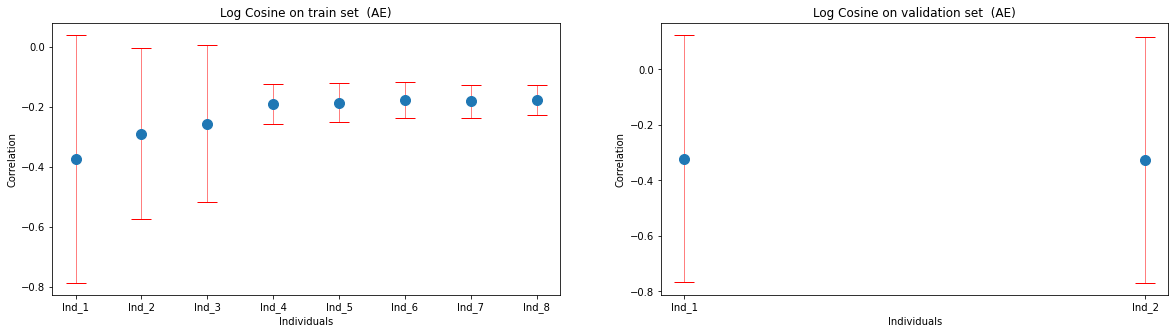

train set mean:  nan
train set std:  nan
validation set mean:  nan
validation set std:  nan


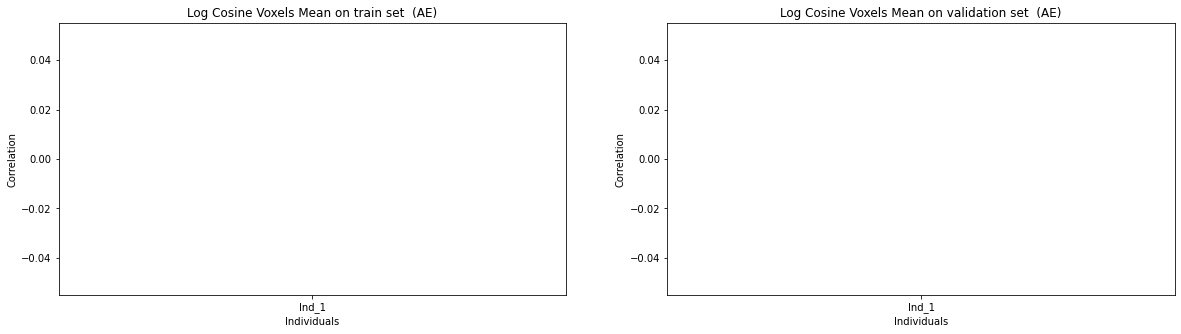

train set mean:  -0.2284509806674631
train set std:  0.18162393262509668
validation set mean:  -0.19257574123056495
validation set std:  0.16455106787830664


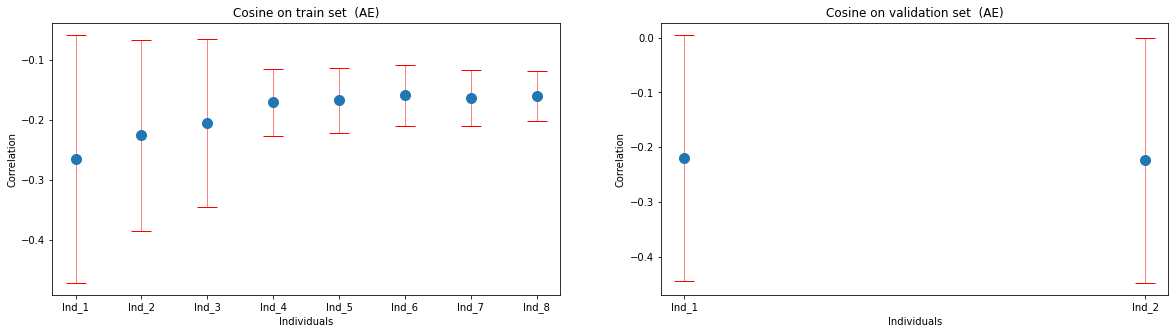

train set mean:  -inf
train set std:  nan
validation set mean:  -inf
validation set std:  nan


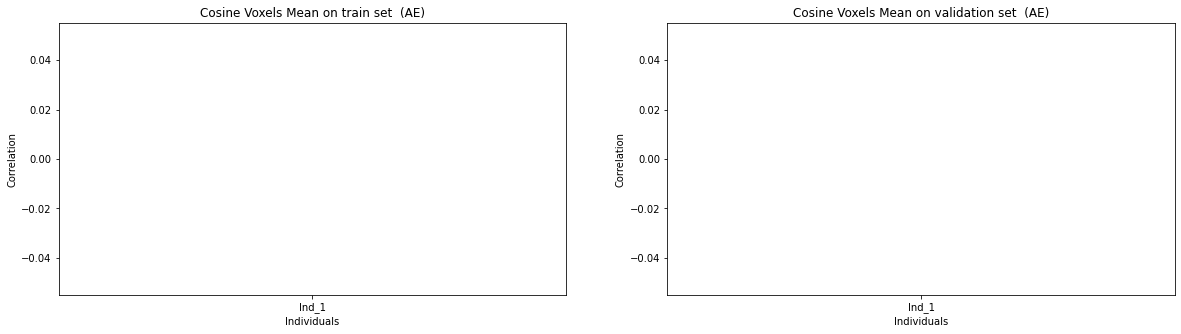

train set mean:  84.7542579314288
train set std:  41.37208611119571
validation set mean:  83.23255000394933
validation set std:  34.43448746228116


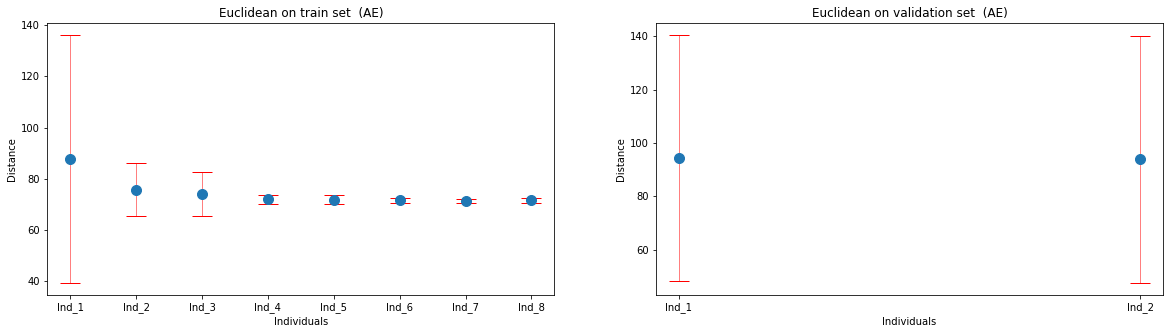

train set mean:  22.303462000454175
train set std:  9.673764209635095
validation set mean:  22.01090150720933
validation set std:  8.064646738543015


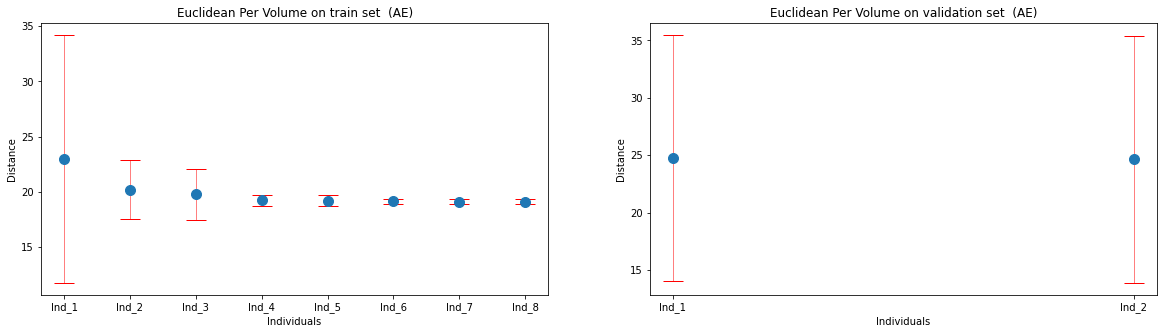

train set mean:  516.9457370533663
train set std:  288.77382433096864
validation set mean:  505.32951893525967
validation set std:  241.49577075116625


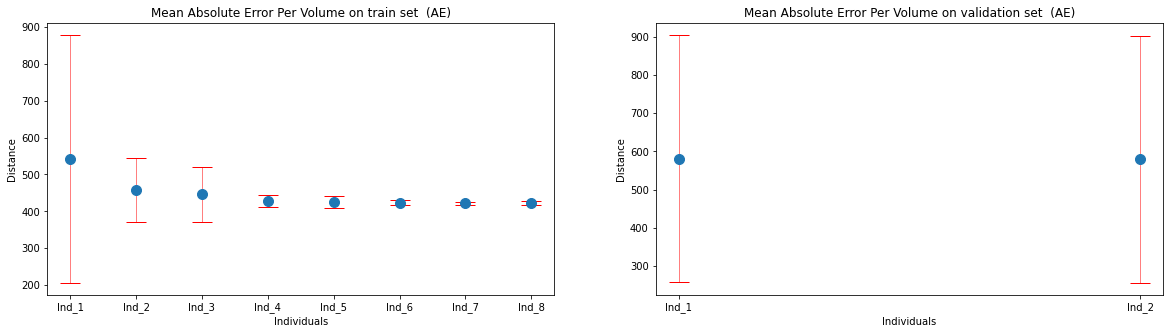

train set mean:  0.4631607672199607
train set std:  0.22872117600375402
validation set mean:  0.4750508057939656
validation set std:  0.20396848651477936


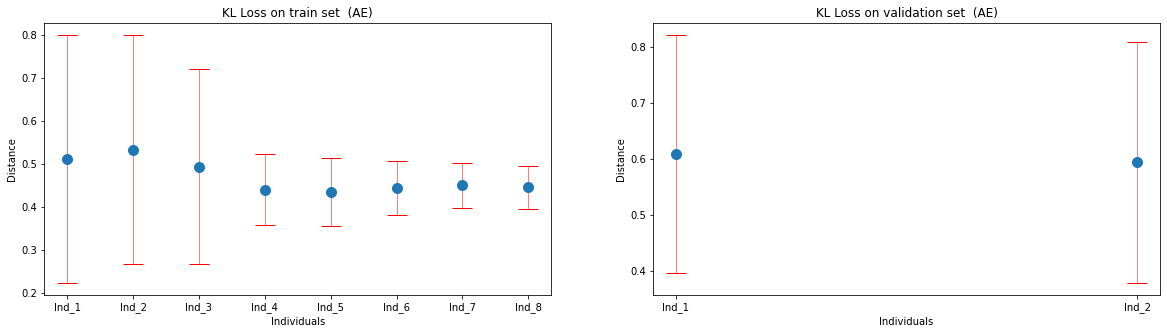

In [15]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Try the same hyperparameters, but in an adversarial training process

In [21]:
import tensorflow as tf
import tensorflow.keras.backend as K


def loss_minmax_discriminator(real_pred, real_true, gen_pred):
    #need to separate positives from negatives

    #log(1) = 0
    positives = np.array([[1., 0., 0.]], dtype='float32').repeat(real_pred.shape[0],0)
    #log(1-1) = 0
    negatives = np.array([[0., 1., 0.]], dtype='float32').repeat(real_pred.shape[0],0)
    for instance in range(real_true.shape[0]):
        if(real_true[instance] == 1.0):
            positives[instance] = real_pred[instance][0].numpy()
        else:
            negatives[instance] = real_pred[instance][0].numpy()

    positives = tf.convert_to_tensor(positives)
    negatives = tf.convert_to_tensor(negatives)
    
    loss = (tf.math.log(positives) + tf.math.log(1. - negatives) + tf.math.log(1. - gen_pred)) / 3.

    return tf.reduce_mean(loss)


def loss_minmax_generator(gen_pred):
    
    return tf.reduce_mean(tf.math.log(gen_pred))

def loss_wasserstein_discriminator(real_pred, real_true, gen_pred):
    #need to separate positives from negatives

    #log(1) = 0
    positives = np.array([[1., 0., 0.]], dtype='float32').repeat(real_pred.shape[0],0)
    #log(1-1) = 0
    negatives = np.array([[0., 1., 0.]], dtype='float32').repeat(real_pred.shape[0],0)
    for instance in range(real_true.shape[0]):
        if(real_true[instance] == 1.0):
            positives[instance] = real_pred[instance][0].numpy()
        else:
            negatives[instance] = real_pred[instance][0].numpy()

    positives = tf.convert_to_tensor(positives)
    negatives = tf.convert_to_tensor(negatives)

    loss = ((tf.constant(np.array([1., 0., 0.]), dtype="float32") - positives) + \
            (tf.constant(np.array([0., 1., 0.]), dtype="float32") - negatives) + \
            (tf.constant(np.array([0., 0., 1.]), dtype="float32") - gen_pred))

    return tf.reduce_mean(loss)


def loss_wasserstein_generator(gen_pred):
    
    return tf.reduce_mean(tf.abs(tf.constant(np.array([1., 0., 0.]), dtype="float32") - gen_pred))

def grad_decoder_adversarial(discriminator, synthesizer, z, eeg, bold, y_pairs, clip=True, clip_value=2, d_loss=losses.loss_minmax_discriminator, g_loss=losses.loss_minmax_generator):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        
        tape.watch(z)
        tape.watch(synthesizer.variables)

        eeg = tf.convert_to_tensor(eeg)
        bold = tf.convert_to_tensor(bold)
                 
        synthesized = synthesizer(z)

        #pair synthesized with eeg
        real_labels = discriminator([eeg, bold])
        gen_labels = discriminator([eeg, synthesized])
        
        discriminator_loss = d_loss(real_labels, y_pairs, gen_labels)
        synthesizer_loss = g_loss(gen_labels)
        
        if(clip):
            discriminator_loss = tf.clip_by_value(discriminator_loss, -clip_value, clip_value)
            synthesizer_loss = tf.clip_by_value(synthesizer_loss, -clip_value, clip_value)

        return synthesizer_loss, discriminator_loss, tape.gradient(synthesizer_loss, 
                                            synthesizer.trainable_weights)

In [22]:
"""
sensitive_adversarial_training: Adversarial Training

Changing from training the D/G based on the accuracy of G/D given a threshold (0.5)
        
"""
def sensitive_adversarial_training(X_train_eeg, X_train_bold, tr_y, eeg_network, 
    decoder_model, multi_modal_model, epochs=10, 
    discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    generator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    g_loss_function=losses.loss_minmax_generator,
    d_loss_function=losses.loss_minmax_discriminator,
    linear_combination=1.0, 
    clip=True,
    clip_value_gradient=0.5, 
    clip_value_loss=2, 
    batch_size=128,
    X_val_eeg=None, X_val_bold=None, tv_y=None, 
    eeg_train=None, bold_train=None, eeg_val=None, bold_val=None,
    X_bold_train_target=None,
    X_bold_val_target=None,
    session=None, verbose=1):


    validation = False
    if(X_val_eeg is not None and X_val_bold is not None and tv_y is not None):
        validation = True

    global_step = tf.Variable(0)
    
    training_d = True
    training_g = False

    _losses = custom_training.custom_training_loss()
    n_epochs = 0

    while(n_epochs < epochs):
        if(training_d):
            print("Training Discriminator")
        elif(training_g):
            print("Training Generator")
        
        decoder_loss = _losses.get_batch_decoder_loss_avg()
        encoder_loss = _losses.get_batch_encoder_loss_avg()
        
        if(training_d and decoder_loss > encoder_loss and encoder_loss != np.inf):
            print("Finished Discriminator\nChanging to Generator")
            training_d = False
            training_g = True
            _losses = custom_training.custom_training_loss()
        elif(training_g and encoder_loss > decoder_loss):
            print("Finished Generator\nChanging to Discriminator")
            training_d = True
            training_g = False
            n_epochs += 1
            _losses = custom_training.custom_training_loss()
        
        for batch_init in range(0, len(X_train_eeg), batch_size):
            batch_start = batch_init
            if(batch_start + batch_size >= len(X_train_eeg)):
                batch_stop = len(X_train_eeg)
            else:
                batch_stop = batch_start + batch_size
            
            shared_eeg = eeg_network(tf.gather_nd(eeg_train, X_train_eeg[batch_start:batch_stop]))
            
            if(training_g):
                # Optimize the synthesizer mode
                decoder_loss, encoder_loss, decoder_grads = grad_decoder_adversarial(multi_modal_model, decoder_model, 
                                                                        shared_eeg,
                                                                        tf.gather_nd(eeg_train, X_train_eeg[batch_start:batch_stop]), 
                                                                        tf.gather_nd(bold_train, X_train_bold[batch_start:batch_stop]), 
                                                                        tr_y[batch_start:batch_stop],
                                                                        d_loss=d_loss_function,
                                                                        g_loss=g_loss_function,
                                                                        clip=clip,
                                                                        clip_value=clip_value_loss)
                with tf.name_scope("gradient_decoder") as scope:
                    generator_optimizer.apply_gradients(zip(decoder_grads, decoder_model.trainable_variables), name=scope)
                
            elif(training_d):
                #now train the compression by correlation model
                encoder_loss, decoder_loss, encoder_grads = custom_training.grad_multi_encoder_adversarial(multi_modal_model, decoder_model, 
                                                                        shared_eeg,
                                                                        tf.gather_nd(eeg_train, X_train_eeg[batch_start:batch_stop]), 
                                                                        tf.gather_nd(bold_train, X_train_bold[batch_start:batch_stop]), 
                                                                        tr_y[batch_start:batch_stop],
                                                                        d_loss=d_loss_function,
                                                                        g_loss=g_loss_function,
                                                                        clip=clip,
                                                                        clip_value=clip_value_loss)
                
                with tf.name_scope("gradient_encoders") as scope:
                    if(clip):
                        encoder_clipped_grads = ()
                        for grad in encoder_grads:
                            encoder_clipped_grads += (tf.clip_by_value(grad, clip_value_min=-clip_value_gradient, clip_value_max=clip_value_gradient), )
                        encoder_grads=encoder_clipped_grads
                        
                    discriminator_optimizer.apply_gradients(zip(encoder_grads, multi_modal_model.trainable_variables), name=scope)
                
            # Track progress
            _losses.update_batch_decoder_loss_avg(decoder_loss)
            _losses.update_batch_encoder_loss_avg(encoder_loss)

        # end epoch
        decoder_loss = _losses.get_batch_decoder_loss_avg()
        encoder_loss = _losses.get_batch_encoder_loss_avg()

        #get validation analyses
        #get validation analyses
        shared_eeg_train = eeg_network(tf.gather_nd(eeg_train, X_train_eeg))
        shared_eeg_val = eeg_network(tf.gather_nd(eeg_val, X_val_eeg))
        train_reconstruction_loss = losses.get_reconstruction_log_cosine_loss(decoder_model(shared_eeg_train), tf.gather_nd(bold_train, X_train_bold))
        val_reconstruction_loss = losses.get_reconstruction_log_cosine_loss(decoder_model(shared_eeg_val), tf.gather_nd(bold_val, X_val_bold))
        
        if(verbose):
            print("GAN Encoder Loss: ", tf.keras.backend.eval(encoder_loss), 
                " || GAN Decoder Loss: ", tf.keras.backend.eval(decoder_loss),
                " || Train Reconstruction Loss: ", tf.keras.backend.eval(train_reconstruction_loss),
                " || Validation Reconstruction Loss: ", tf.keras.backend.eval(val_reconstruction_loss))
            sys.stdout.flush()

    shared_eeg_val = eeg_network(tf.gather_nd(eeg_val, X_val_eeg))
    return tf.keras.backend.eval(custom_training.loss_decoder(decoder_model(shared_eeg_val), tf.gather_nd(bold_val, X_val_bold)))

In [32]:
import importlib
importlib.reload(custom_training)
importlib.reload(losses)

eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, 
                                                        dcca=False, 
                                                        lstm=True,
                                                        corr_distance=False,
                                                        dist_function=losses.correlation,
                                                        gan=True,
                                                        gan_activation="sigmoid",
                                                        gan_output_dimension=1)
mode="gan_lstm_zeeg_zfmri"
validation_loss = custom_training.adversarial_training(X_train_eeg, 
                                       X_train_bold, 
                                       tr_y, 
                                       eeg_network, decoder_network, multi_modal_model, 
                                       epochs=5, 
                                       discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                       generator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                       batch_size=batch_size, 
                                       g_loss_function=loss_wasserstein_generator,
                                       d_loss_function=loss_wasserstein_discriminator,
                                       linear_combination=loss_coefficient, 
                                       clip=True,
                                       clip_value_gradient=25.0,
                                        clip_value_loss=20.0, 
                                       X_val_eeg=X_val_eeg, 
                                       X_val_bold=X_val_bold, 
                                       tv_y=tv_y,
                                       eeg_train=eeg_train, 
                                       bold_train=bold_train, 
                                       eeg_val=eeg_val, 
                                       bold_val=bold_val,
                                       X_bold_train_target=X_bold_train_target,
                                       X_bold_val_target=X_bold_val_target)

model_name = "GAN"

GAN Encoder Loss:  -0.2416613  || GAN Decoder Loss:  0.26248035  || GAN Validation Decoder Loss:  -0.34960738  || Train Reconstruction Loss:  -0.24042429  || Validation Reconstruction Loss:  -0.34960738
GAN Encoder Loss:  -0.31586298  || GAN Decoder Loss:  0.27488244  || GAN Validation Decoder Loss:  -0.34953785  || Train Reconstruction Loss:  -0.24039538  || Validation Reconstruction Loss:  -0.34953785
GAN Encoder Loss:  -0.3529188  || GAN Decoder Loss:  0.2810485  || GAN Validation Decoder Loss:  -0.34950626  || Train Reconstruction Loss:  -0.24043576  || Validation Reconstruction Loss:  -0.34950626
GAN Encoder Loss:  -0.3874967  || GAN Decoder Loss:  0.28681013  || GAN Validation Decoder Loss:  -0.34881568  || Train Reconstruction Loss:  -0.2402238  || Validation Reconstruction Loss:  -0.34881568
GAN Encoder Loss:  -0.41928506  || GAN Decoder Loss:  0.2921063  || GAN Validation Decoder Loss:  -0.34602916  || Train Reconstruction Loss:  -0.23922749  || Validation Reconstruction Loss:

train set mean:  -0.3277461887611186
train set std:  0.39041411032307133
validation set mean:  -0.2667034052531509
validation set std:  0.3449954269974931


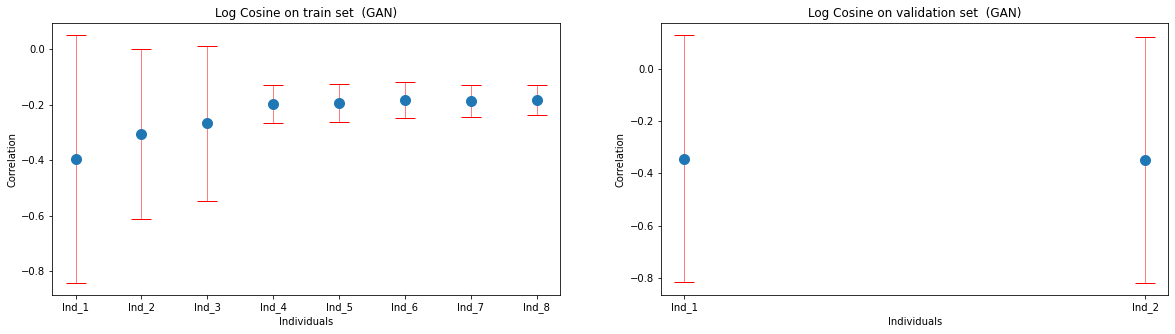

train set mean:  nan
train set std:  nan
validation set mean:  nan
validation set std:  nan


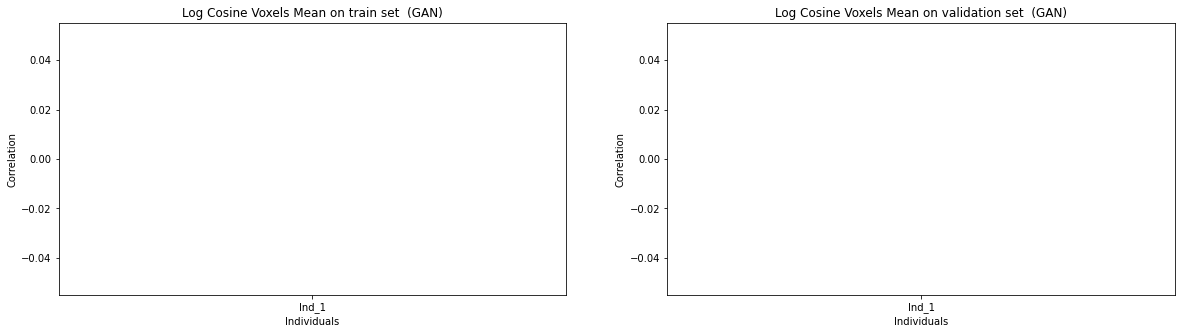

train set mean:  -0.2381271710345412
train set std:  0.18914295193320738
validation set mean:  -0.2010143382803482
validation set std:  0.16825232780883242


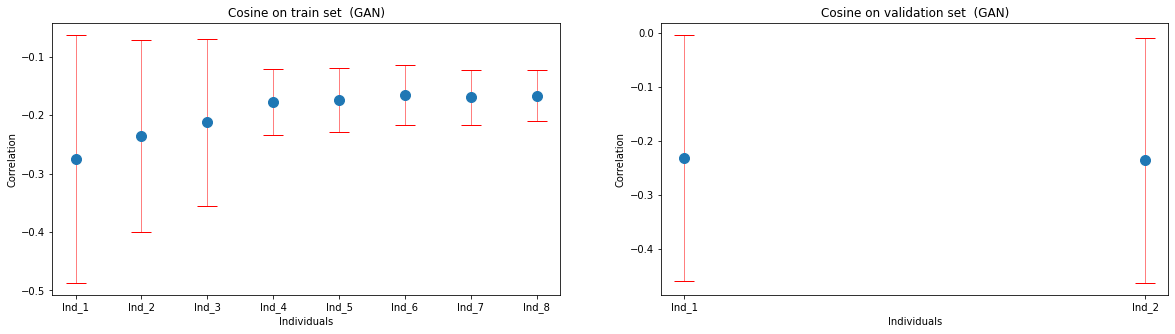

train set mean:  -inf
train set std:  nan
validation set mean:  -inf
validation set std:  nan


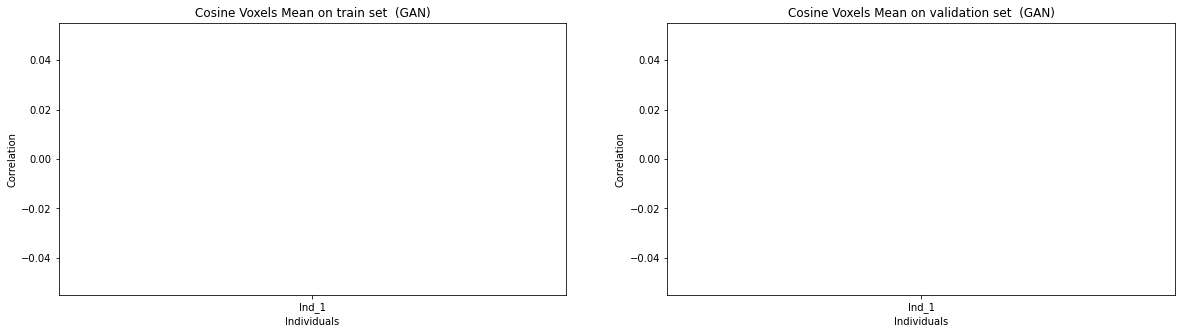

train set mean:  103.7439650928273
train set std:  46.5436921287271
validation set mean:  102.33248564776252
validation set std:  38.65285104829647


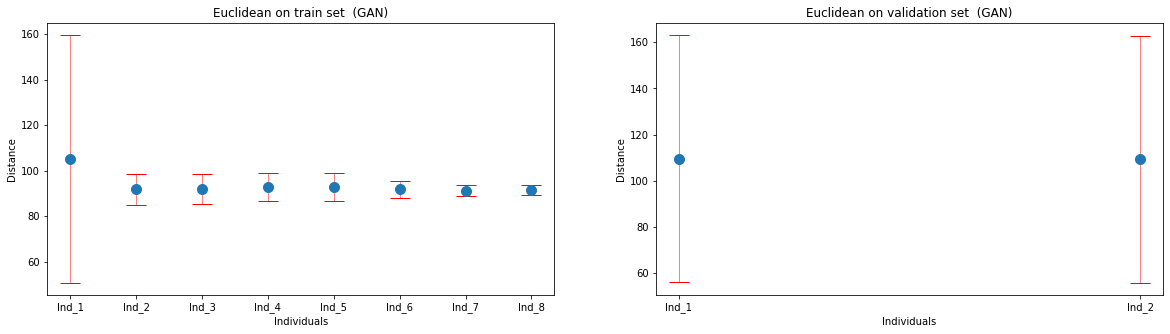

train set mean:  27.418384019066306
train set std:  11.209953229321936
validation set mean:  27.136802336748907
validation set std:  9.322243053471977


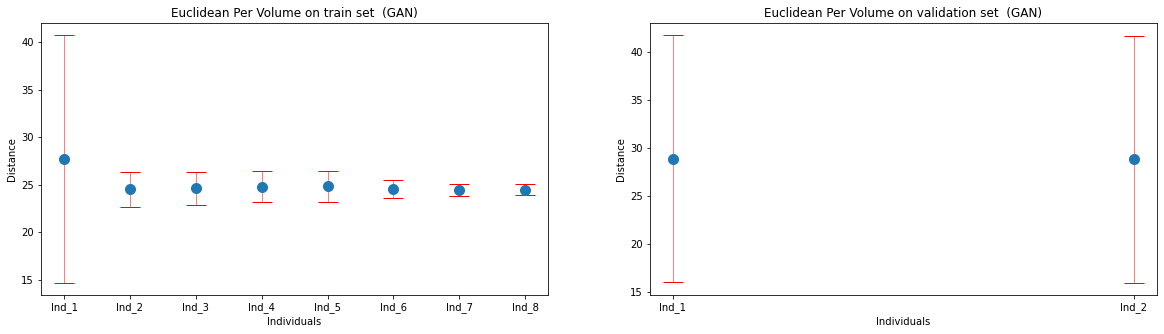

train set mean:  670.0245980655445
train set std:  334.1169274058983
validation set mean:  657.2064164105584
validation set std:  279.56706788152917


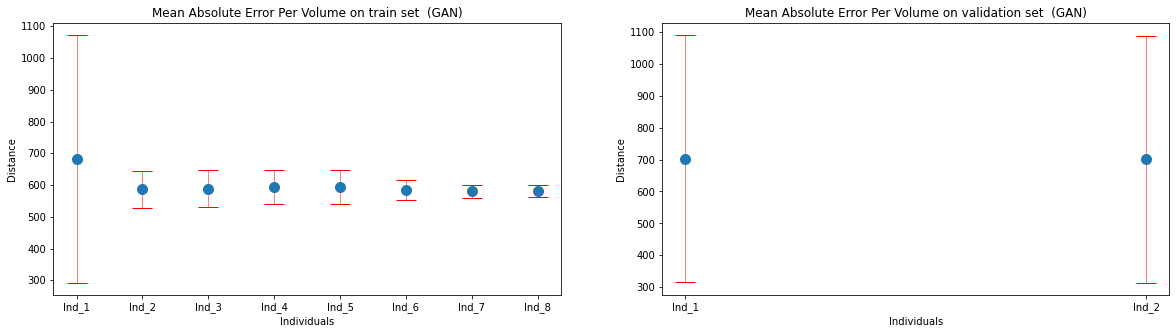

train set mean:  0.005501877979922402
train set std:  0.05866936939545509
validation set mean:  0.0028987580601150353
validation set std:  0.04355825949966676


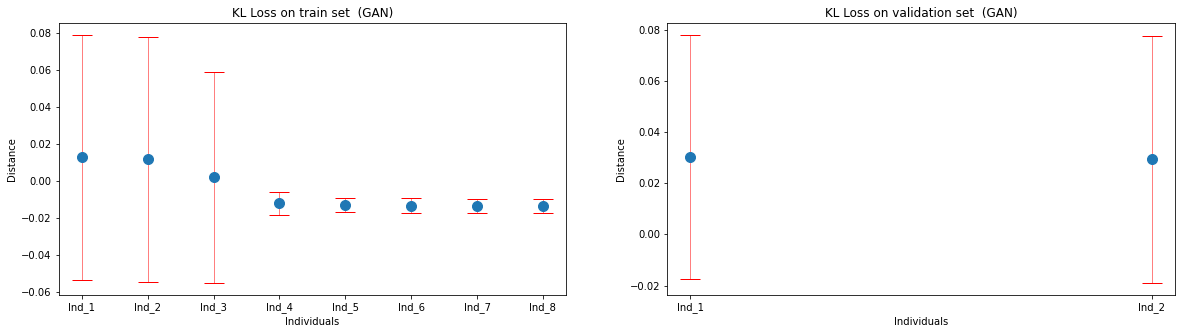

In [33]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Try to check if alternate training between LComb and GAN training

In [110]:
#eeg_network, bold_network, decoder_network = get_models_and_shapes()

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)


validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=5, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=batch_size, 
                                                            linear_combination=loss_coefficient,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y)

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False, corr_distance=True)

validation_loss = custom_training.adversarial_training(X_train_eeg, 
                                                       X_train_bold, 
                                                       tr_y, 
                                                       eeg_network, decoder_network, multi_modal_model, 
                                                       epochs=5, 
                                                       discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       generator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       batch_size=batch_size, 
                                                       linear_combination=loss_coefficient, 
                                                       X_val_eeg=X_val_eeg, 
                                                       X_val_bold=X_val_bold, 
                                                       tv_y=tv_y)

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

train set mean:  -0.13035505447935844
train set std:  0.10439693812962365
validation set mean:  -0.2702327285494123
validation set std:  0.007279591704164774
test set mean:  -0.2692250900325321
test set std:  0.013276322805917784


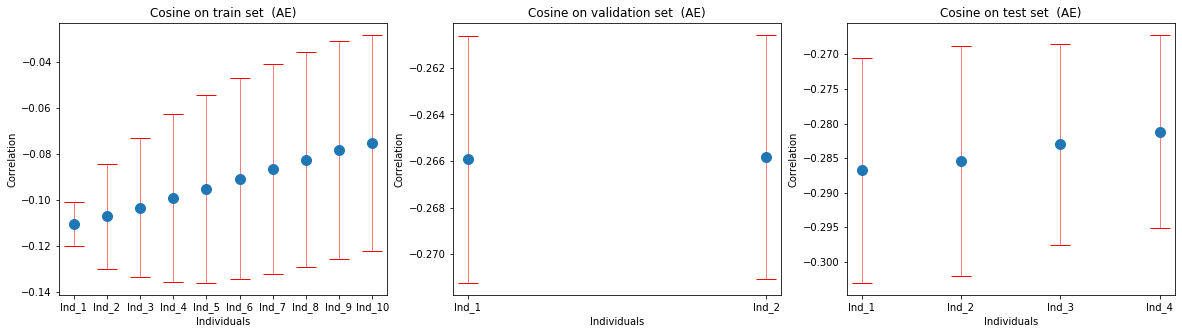

train set mean:  217.21822008405414
train set std:  33.241409173264245
validation set mean:  1998.391369047619
validation set std:  2.57665969646488
test set mean:  1995.119361514137
test set std:  6.124074982564129


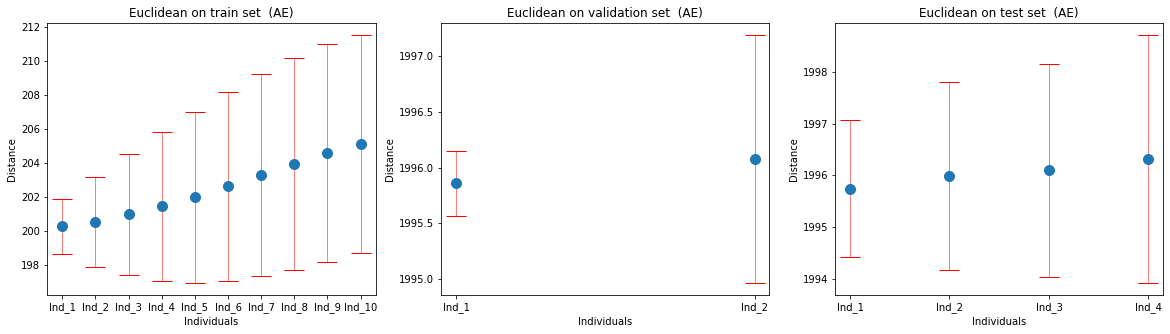

In [31]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Top-K ranking synthesis

In [12]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, 
                                                        corr_distance=True,
                                                        dist_function=losses.euclidean,#mean_volume_abs/euclidean /kl_loss
                                                        lstm=True,
                                                        gan=False,
                                                        gan_activation="softmax",
                                                        gan_output_dimension=1)


validation_loss = custom_training.ranked_synthesis_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            bold_network=bold_network, 
                                                            epochs=5, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            loss_function=losses.get_reconstruction_euclidean_volume_loss,
                                                            batch_size=batch_size, 
                                                            top_k=5, 
                                                            eeg_train=eeg_train, 
                                                            bold_train=bold_train, 
                                                            eeg_val=eeg_val, 
                                                            bold_val=bold_val,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y)

model_name="Top-5"


#1 - 
#2 - 
#3 - 
#4 - 
#5 - 
#6 - 
#7 - 
#8 - 
#9 - 
#10 - 

Encoder Loss:  0.24242112
Encoder Loss:  0.21802038
Encoder Loss:  0.25558707
Encoder Loss:  0.18090014
Encoder Loss:  0.270986
Decoder Loss:  34.105663 Validation Decoder Loss:  32.48569
Decoder Loss:  31.943863 Validation Decoder Loss:  30.427752
Decoder Loss:  29.932602 Validation Decoder Loss:  28.547352
Decoder Loss:  28.11178 Validation Decoder Loss:  26.888727
Decoder Loss:  26.525572 Validation Decoder Loss:  25.49716


train set mean:  -0.32776923285906806
train set std:  0.39065619783091343
validation set mean:  -0.2661297588663943
validation set std:  0.3426085435958356


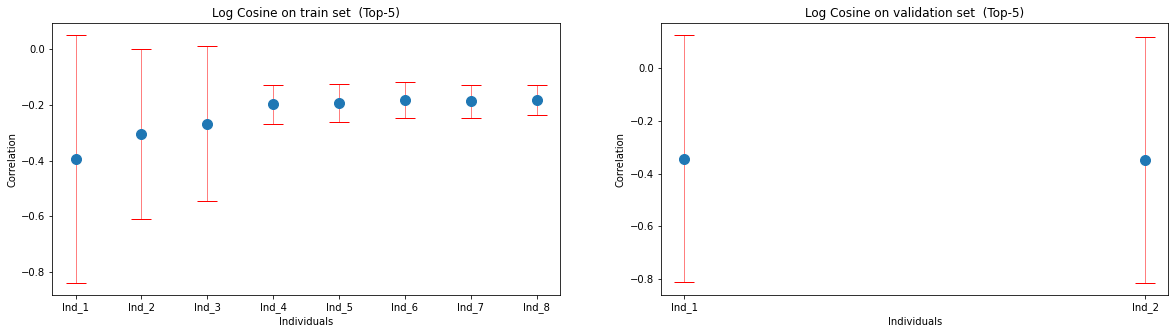

train set mean:  nan
train set std:  nan
validation set mean:  nan
validation set std:  nan


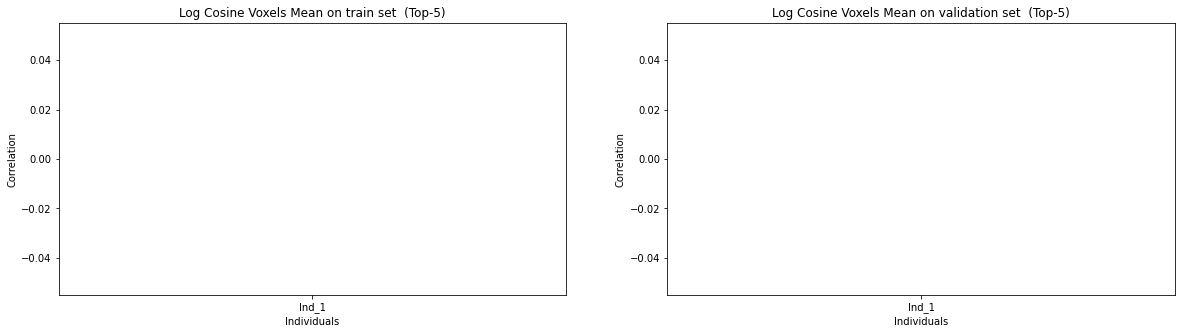

train set mean:  -0.2381008119760629
train set std:  0.1891978744774944
validation set mean:  -0.20093231056542957
validation set std:  0.16773219879041282


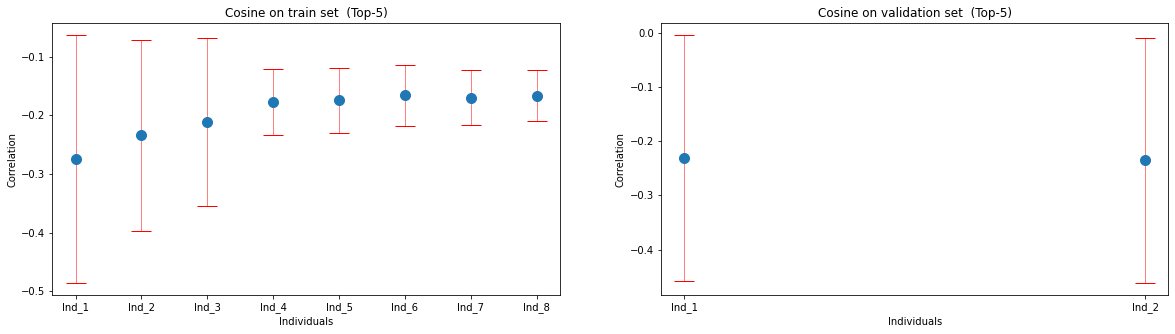

train set mean:  -inf
train set std:  nan
validation set mean:  -inf
validation set std:  nan


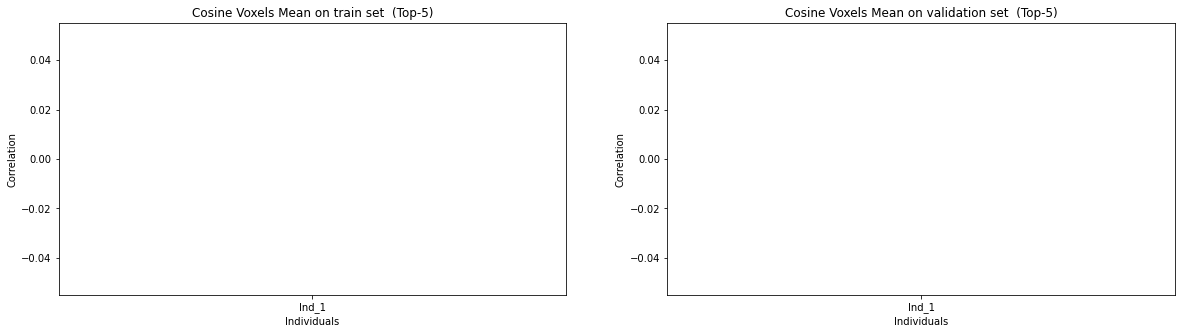

train set mean:  111.19397247538848
train set std:  47.462675317106786
validation set mean:  110.80535798914292
validation set std:  39.025841044789836


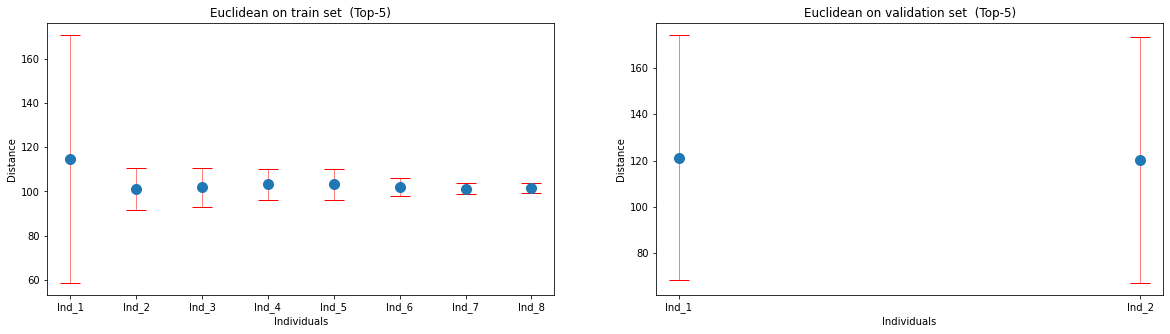

train set mean:  29.409105076509363
train set std:  11.497717430188871
validation set mean:  29.39408369625316
validation set std:  9.435642414766257


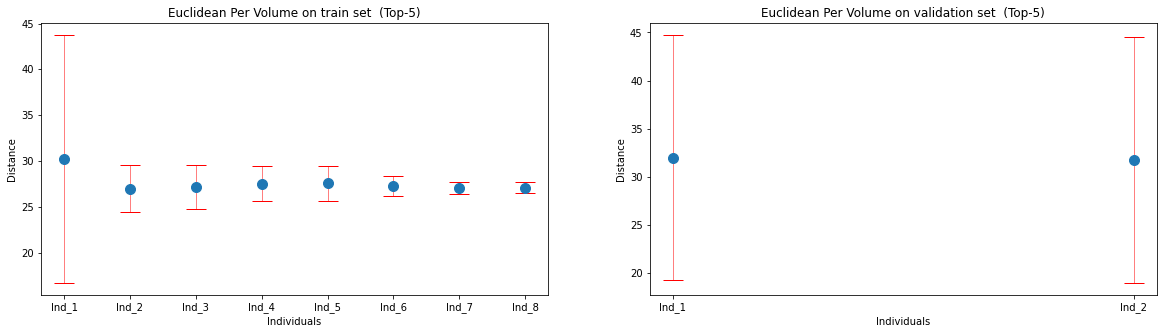

train set mean:  730.0296949498794
train set std:  343.3302814556333
validation set mean:  725.4984777113971
validation set std:  282.2232577053794


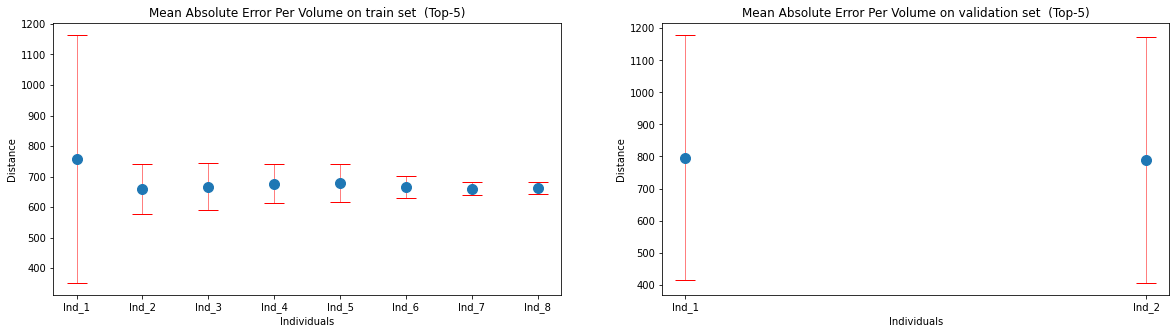

train set mean:  -0.04324554894564619
train set std:  0.043645790272329926
validation set mean:  -0.04712774029330296
validation set std:  0.04049326777334801


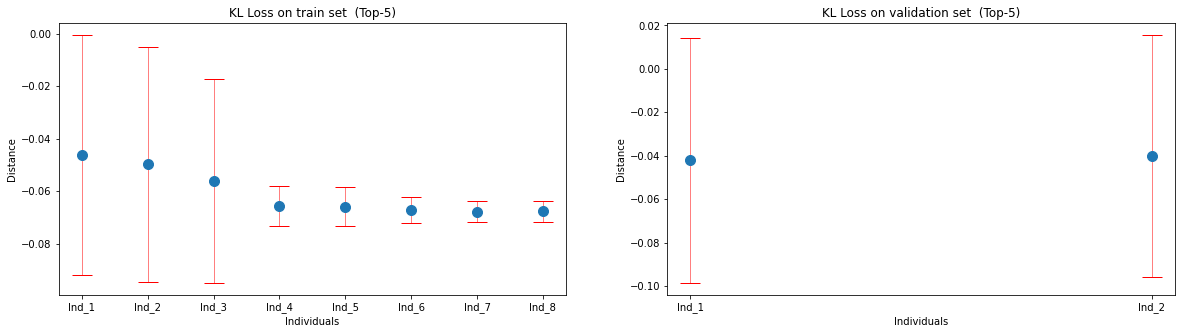

In [13]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)